In [1]:
from pyomo.environ import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
# Create a Pyomo model
model = ConcreteModel()

In [3]:
model.beta = Param(initialize=0.5)      # Infectivity rate
model.gamma = Param(initialize=0.25)    # Recovery rate
model.v_max = Param(initialize=0.5)     # Maximum intervention
model.v_total = Param(initialize=10.0)  # Maximum cost
model.t0 = Param(initialize=0.0)
model.tf = Param(initialize=100.0)
model.dt = Param(initialize=2.0)
model.S0 = Param(initialize=0.99)
model.I0 = Param(initialize=0.01)
model.C0 = Param(initialize=0.00)

In [4]:
model.T = Param(initialize=lambda m: int(m.tf / m.dt))

In [5]:
model.T_set = RangeSet(1, model.T + 1)
model.T_range = RangeSet(1, model.T)

In [6]:
model.S = Var(model.T_set, bounds=(0, 1))
model.I = Var(model.T_set, bounds=(0, 1))
model.C = Var(model.T_set, bounds=(0, 1))
model.v = Var(model.T_set, bounds=(0, model.v_max))

In [7]:
# Initial conditions
def initial_condition_S_rule(m):
    return m.S[1] == m.S0
model.InitialConditionS = Constraint(rule=initial_condition_S_rule)

def initial_condition_I_rule(m):
    return m.I[1] == m.I0
model.InitialConditionI = Constraint(rule=initial_condition_I_rule)

def initial_condition_C_rule(m):
    return m.C[1] == m.C0
model.InitialConditionC = Constraint(rule=initial_condition_C_rule)


In [8]:
# Total intervention cost constraint
def total_cost_rule(m):
    return m.dt * sum(m.v[t] for t in m.T_set) <= m.v_total
model.TotalCostConstraint = Constraint(rule=total_cost_rule)


In [9]:
# Nonlinear expressions for infection and recovery rates
model.infection = Var(model.T_range, bounds=(0, None))
model.recovery = Var(model.T_range, bounds=(0, None))

In [10]:
# Define infection and recovery explicitly as constraints
def infection_rule(m, t):
    return m.infection[t] == (1 - exp(-(1 - m.v[t]) * m.beta * m.I[t] * m.dt)) * m.S[t]
model.DefineInfection = Constraint(model.T_range, rule=infection_rule)

def recovery_rule(m, t):
    return m.recovery[t] == (1 - exp(-m.gamma * m.dt)) * m.I[t]
model.DefineRecovery = Constraint(model.T_range, rule=recovery_rule)


In [11]:
# Nonlinear differential equations
def susceptible_rule(m, t):
    return m.S[t + 1] == m.S[t] - m.infection[t]
model.SusceptibleConstraint = Constraint(model.T_range, rule=susceptible_rule)

def infected_rule(m, t):
    return m.I[t + 1] == m.I[t] + m.infection[t] - m.recovery[t]
model.InfectedConstraint = Constraint(model.T_range, rule=infected_rule)

def cumulative_infection_rule(m, t):
    return m.C[t + 1] == m.C[t] + m.infection[t]
model.CumulativeInfectionConstraint = Constraint(model.T_range, rule=cumulative_infection_rule)


In [12]:
# Objective: Minimize cumulative infections at the final time
def objective_rule(m):
    return m.C[m.T + 1]
model.TotalCumulativeInfections = Objective(rule=objective_rule, sense=minimize)


In [13]:
solver = SolverFactory("ipopt")
solver.options["output_file"] = "pyomo_ipopt_log.txt"  
solver.options["print_timing_statistics"] = "yes"

In [14]:
solver.solve(model, tee=True)

Ipopt 3.14.17: output_file=pyomo_ipopt_log.txt
print_timing_statistics=yes


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:      803
Number of nonzeros in inequality constraint Jacobian.:       51
Number of nonzeros in Lagrangian Hessian.............:      250

Total number of variables............................:      304
                     variables with only lower bounds:      100
                variables with lower and upper bounds:      204
                     variables with only upper bounds:        0
Total number of 

{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 254, 'Number of variables': 304, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.14.17\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 0.07893800735473633}], 'Solution': [OrderedDict({'number of solutions': 0, 'number of solutions displayed': 0})]}

In [15]:
S_opt = [model.S[t].value for t in range(1,model.T+2)]
I_opt = [model.I[t].value for t in range(1,model.T+2)]
C_opt = [model.C[t].value for t in range(1,model.T+2)]
υ_opt = [model.v[t].value for t in range(1,model.T+2)]

ts = np.arange(0, model.tf + model.dt, model.dt)

t1 = 14.338623046875002
t2 = t1 + model.v_total / model.v_max

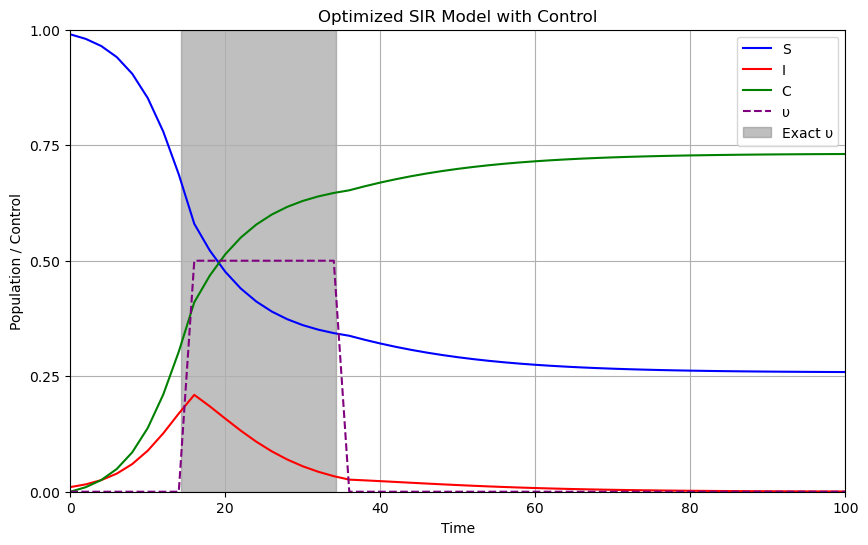

In [16]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(ts, S_opt, label="S", color="blue")
plt.plot(ts, I_opt, label="I", color="red")
plt.plot(ts, C_opt, label="C", color="green")
plt.plot(ts, υ_opt, label="υ", color="purple", linestyle="dashed")
plt.axvspan(t1, t2, color="gray", alpha=0.5, label="Exact υ")
plt.xlabel("Time")
plt.ylabel("Population / Control")
plt.ylim(0, 1)
plt.yticks(np.arange(0, 1.1, step=0.25))
plt.xlim(0, 100)
plt.title("Optimized SIR Model with Control")
plt.legend()
plt.grid()
plt.show()

In [17]:
# Timesteps are consistent with the ones in the model
timesteps = np.arange(1, model.T + 2) 

# Extract values from the DataFrame using the index
data = pd.DataFrame({
    "timestep": timesteps,
    "S": S_opt,
    "I": I_opt,
    "C": C_opt,
    "υ": υ_opt
})

# Save to CSV
data.to_csv("pyomo_results.csv", index=False)